## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
plt.style.use("ggplot")

from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential
from datetime import datetime, timedelta

Using TensorFlow backend.


### Loading the data

In [2]:
df=pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


Extract Close value as our target, the only variable here is date, since it's a Time Series Forecasting problem.
There is no null value and the values are continious, even on weekends, there is no missing value, so we don't need to do much feature engineering or EDA, but we can still visualize it to see the trend within five years.

## Data preprocessing

In [0]:
# Setting the datetime index as the date, only selecting the 'Close' column, then only the last 1000 closing prices.
df = df.set_index("Date")[['Close']].tail(1000)
df = df.set_index(pd.to_datetime(df.index))

# Normalizing/Scaling the Data
sc = MinMaxScaler()
df = pd.DataFrame(sc.fit_transform(df), columns=df.columns, index=df.index)

In [4]:
df.head()

,Close
Date,
2017-03-08,0.011448
2017-03-09,0.013522
2017-03-10,0.009655
2017-03-11,0.012840
2017-03-12,0.015294


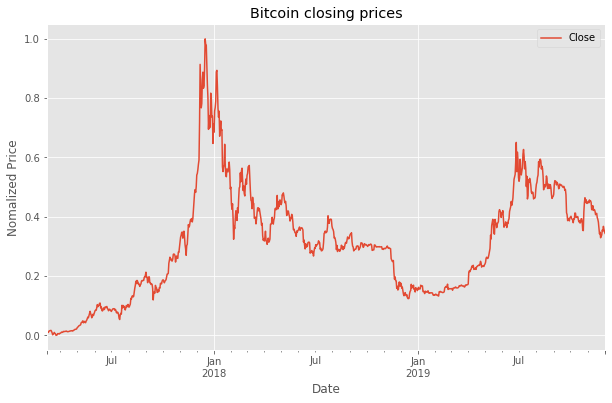

In [5]:
# Visualization for the scaled closing price
df.plot(figsize=(10,6))
plt.title('Bitcoin closing prices')
plt.ylabel('Nomalized Price')
plt.show()

---
## Prepare functions for the model
---

In [0]:
# Split the univariate time sequence
def split_sequence(seq, n_step_in, n_step_out):
    x, y=[],[]
    for i in range(len(seq)):
        end = i+n_step_in
        out_end= end+n_step_out
        
        if out_end>len(seq):
            break
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        x.append(seq_x)
        y.append(seq_y)
        
    return np.array(x), np.array(y)

In [0]:
# Plot the loss and accuracy for the training and testing data
def visualize_training_results(results):
    history= results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss','loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy','accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [0]:
# Create the model archetecture
def layer_maker(n_layers,n_nodes, drop=None):
    for x in range(1, n_layers+1):
        model.add(LSTM(n_nodes, activation= 'relu', return_sequences= True))
        model.add(Dropout(.2)) 

### Split the data

We look back 30 days price history to predict the next 10 days, in this way, for each day of the 1000+ days in our dataset, the previous 30 days are used to determine any patterns or sequences that lead to the next 10 days.

In [0]:
# The periods look back to learn
look_back=30

# Predict period
look_forward=20

# Features ("Price" in this case)
n_features=1

# Split the data into proper sequences
x,y=split_sequence(list(df.Close),look_back,look_forward)

# Reshaping the x variable from 2D to 3D
x=x.reshape((x.shape[0],x.shape[1],n_features))

## Modeling-LSTM

In [11]:
# Instantiating the model
model=Sequential()

# Input layer
model.add(LSTM(30, activation='relu',return_sequences=True,input_shape=(look_back, n_features)))

# Hidden layers
layer_maker(n_layers=6, n_nodes=12)

#Final hidden layer
model.add(LSTM(10,activation='tanh'))

# output layer
model.add(Dense(look_forward))

#Model summary
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 12)            2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 12)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 12)            1200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 12)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 12)            1200      
_

In [0]:
# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

### Fitting and training the RNN

In [15]:
res= model.fit(x,y, epochs=100, batch_size= 32,validation_split=0.1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 855 samples, validate on 96 samples
Epoch 1/100





855/855 [==============================] - 11s 13ms/step - loss: 0.1154 - acc: 0.0351 - val_loss: 0.1516 - val_acc: 0.0312
Epoch 2/100
855/855 [==============================] - 4s 5ms/step - loss: 0.0752 - acc: 0.0386 - val_loss: 0.0654 - val_acc: 0.0104
Epoch 3/100
855/855 [==============================] - 4s 5ms/step - loss: 0.0392 - acc: 0.0433 - val_loss: 0.0193 - val_acc: 0.0104
Epoch 4/100
855/855 [==============================] - 4s 5ms/step - loss: 0.0202 - acc: 0.0538 - val_loss: 0.0061 - val_acc: 0.0104
Epoch 5/100
855/855 [==============================] - 4s 5ms/step - loss: 0.0148 - acc: 0.0713 - val_loss: 0.0034 - val_acc: 0.0312
Epoch 6/100
855/855 [==============================] - 4s 5ms/step - loss: 0.0142 - acc: 0.0573 - val_loss: 0.0033 - val_acc: 0.0312
Epoch 7/100
855/855 [==============================] 

### Visualize the accuracy and loss

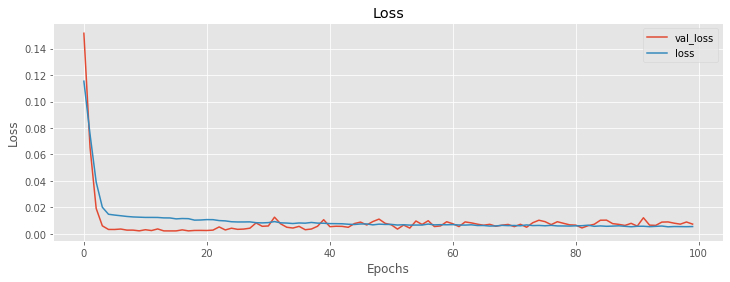

KeyError: ignored

<Figure size 864x288 with 0 Axes>

In [16]:
visualize_training_results(res)

## Visualizing the predictions

Predicted Prices:
 [[7617.219263660089], [7909.460879752283], [7274.749795198069], [7568.550677820713], [7390.153218532569], [7302.087570650691], [7587.5058054304955], [7330.861265192725], [7335.386401583504], [7496.436675015684], [7598.071094539442], [7507.4599537263375], [7710.565620150056], [7739.505252953577], [7678.017383286708], [7524.571507250988], [7707.70207888431], [7584.558741906468], [7959.777785655776], [8014.919069948264]]

Actual Prices:
 [[8808.262695], [8708.094727], [8491.992188], [8550.760742], [8577.975586], [8309.286133], [8206.145508], [8027.268066], [7642.75], [7296.577637], [7397.796875], [7047.9169919999995], [7146.133789], [7218.371094], [7531.663573999999], [7463.105956999999], [7761.243651999999], [7569.629883], [7424.29248], [7321.988281]]


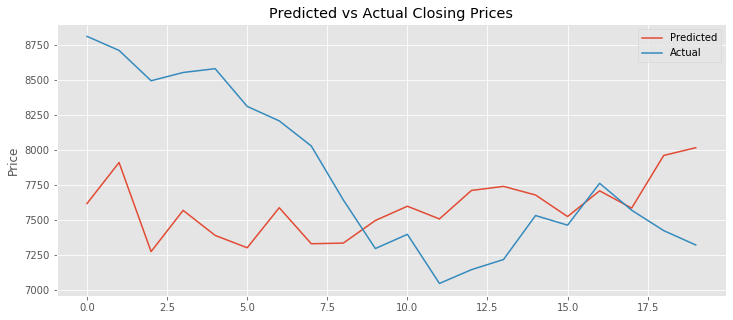

The  Mean Squared Error:  478346.93974497


In [19]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(x[-1].reshape(1, look_back, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = sc.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = sc.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.savefig("BTC_validation.png")
plt.show()

MSE = np.square(np.subtract(actual,yhat)).mean() 
print("The  Mean Squared Error: ", MSE)

### Predicting the future prices

                  Close
2019-12-02  6613.736390
2019-12-03  6953.105025
2019-12-04  6378.163796
2019-12-05  6677.598836
2019-12-06  6482.668395
2019-12-07  6493.255809
2019-12-08  6601.419899
2019-12-09  6556.048506
2019-12-10  6491.459804
2019-12-11  6727.066138
2019-12-12  6602.533345
2019-12-13  6797.789025
2019-12-14  6737.161269
2019-12-15  6840.885404
2019-12-16  6751.736733
2019-12-17  6828.737617
2019-12-18  6896.387328
2019-12-19  6889.739841
2019-12-20  6988.938840
2019-12-21  6955.783269


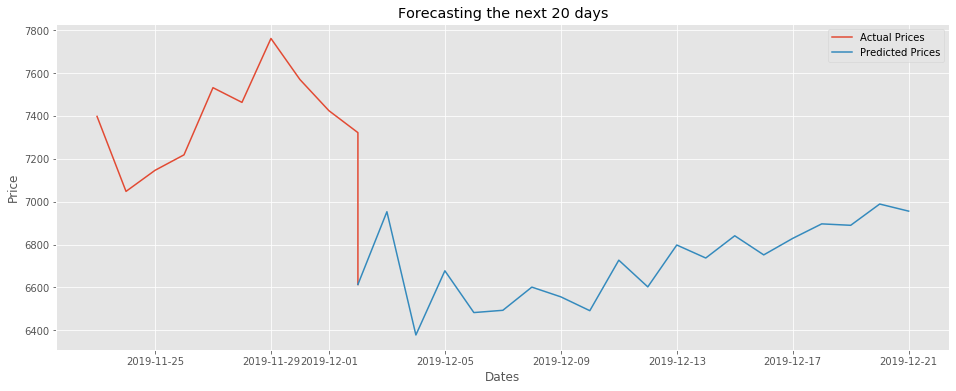

In [18]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(look_back)).reshape(1, look_back, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = sc.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual = pd.DataFrame(sc.inverse_transform(df[["Close"]].tail(pers)), index=df.Close.tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
plt.savefig("BTC_predictions.png")
plt.show()

### MSE LSTM

In [ ]:
MSE = np.square(np.subtract(actual,yhat)).mean() 
print("The  Mean Squared Error: ", MSE)

The  Mean Squared Error:  478346.93974497